In [30]:
%matplotlib inline
import glob, os, sys
from astropy import coordinates as coords
from astropy import units as u
from astropy import constants as const

from astropy.io import fits
from astropy.io.fits import getdata
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM

import numpy.polynomial.polynomial as poly

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['axes.linewidth'] = 1.5

### Read Light Curve Data

Get C3 g-band light curves:

Y1-Y6:

`with SNVAR_TEMP_1 as (select CATALOGNAME, MAG_ZERO, SIGMA_MAG_ZERO, MAG_ONE, SIGMA_MAG_ONE, MJD_OBS from  Y6A1_EXPOSURE join Y6A1_ZEROPOINT on Y6A1_EXPOSURE.expnum = Y6A1_ZEROPOINT.expnum where field like 'SN-C3' and Y6A1_ZEROPOINT.flag < 16 and Y6A1_ZEROPOINT.source='FGCM' and Y6A1_ZEROPOINT.version='y6a1_v2.1' and MJD_OBS>56400 and EXPTIME > 30 order by CATALOGNAME ) select RA, DEC, MJD_OBS, Y6A1_FINALCUT_OBJECT.FLUX_PSF*POWER(10,-0.4*MAG_ZERO+9) as FLUX_PSF, SQRT(POWER(1.09*SIGMA_MAG_ZERO*Y6A1_FINALCUT_OBJECT.FLUX_PSF, 2) + POWER(Y6A1_FINALCUT_OBJECT.FLUXERR_PSF, 2))*POWER(10,-0.4*MAG_ZERO+9) as FLUXERR_PSF, SPREAD_MODEL, BAND from  Y6A1_FINALCUT_OBJECT, SNVAR_TEMP_1 where CATALOGNAME = FILENAME and BAND='g' order by DEC, RA; > /data/des80.a/data/cburke/y6a1_c3_g_light_curves.csv`

SV:

`with SNVAR_TEMP_1 as (select CATALOGNAME, MAG_ZERO, SIGMA_MAG_ZERO, MAG_ONE, SIGMA_MAG_ONE, MJD_OBS from  Y4A1_EXPOSURE join Y4A1_ZEROPOINT on Y4A1_EXPOSURE.expnum = Y4A1_ZEROPOINT.expnum where field like 'SN-C3' and Y4A1_ZEROPOINT.flag < 16 and Y4A1_ZEROPOINT.source = 'FGCM' and Y4A1_ZEROPOINT.version='v2.0' and MJD_OBS<56400 and EXPTIME > 30 order by CATALOGNAME ) select RA, DEC, MJD_OBS, Y4A1_FINALCUT_OBJECT.FLUX_PSF*POWER(10,-0.4*MAG_ZERO+9) as FLUX_PSF, SQRT(POWER(1.09*SIGMA_MAG_ZERO*Y4A1_FINALCUT_OBJECT.FLUX_PSF, 2) + POWER(Y4A1_FINALCUT_OBJECT.FLUXERR_PSF, 2))*POWER(10,-0.4*MAG_ZERO+9) as FLUXERR_PSF, SPREAD_MODEL, BAND  from Y4A1_FINALCUT_OBJECT, SNVAR_TEMP_1 where CATALOGNAME = FILENAME and BAND='g' order by DEC, RA; > /data/des80.a/data/cburke/sv_c3_g_light_curves.csv`

In [2]:
# Read light curves
files = glob.glob('data/*_c3_g_light_curves*.csv')
print(files)
files = [files[0]] # TEST!!
df_lc_psf = pd.concat([pd.read_csv(f) for f in files], axis=0, join='inner')
# Lower-case column names
df_lc_psf.columns = df_lc_psf.columns.str.lower()
df_lc_psf['roms'] = [-1]*len(df_lc_psf)
# Combine on RA, dec (effectively match to 0.5 arcsec)
df_lc_psf['ra_as'] = np.around(df_lc_psf['ra']*3600*2,0)/2.0 # deg->arcsec
df_lc_psf['dec_as'] = np.around(df_lc_psf['dec']*3600*2,0)/2.0 # deg->arcsec
coord_unique = np.unique(np.array([df_lc_psf['ra_as'],df_lc_psf['dec_as']]).T,axis=0)
# Create SkyCoord
coord_des_psf = SkyCoord(coord_unique[:,0],coord_unique[:,1],unit=u.arcsec)

['data/y6a1_c3_g_light_curves_000003.csv', 'data/y6a1_c3_g_light_curves_000002.csv', 'data/sv_c3_g_light_curves.csv', 'data/y6a1_c3_g_light_curves_000004.csv', 'data/y6a1_c3_g_light_curves_000001.csv']


In [3]:
df_lc_psf

,ra,dec,mjd_obs,flux_psf,fluxerr_psf,spread_model,band,roms,ra_as,dec_as
0,52.979943,-27.998125,57991.392933,0.231310,0.027588,0.023996,g,-1,190728.0,-100793.0
1,53.209312,-27.998125,56963.255308,0.604437,0.126274,-0.000651,g,-1,191553.5,-100793.0
2,53.266195,-27.998125,57791.057792,1.093736,0.170112,-0.010241,g,-1,191758.5,-100793.0
3,53.569008,-27.998125,58021.192553,0.365285,0.035472,0.007979,g,-1,192848.5,-100793.0
4,53.569045,-27.998125,58112.185543,0.268787,0.027126,0.022873,g,-1,192848.5,-100793.0
...,...,...,...,...,...,...,...,...,...,...
13919995,52.033497,-27.520045,58064.334536,1.416612,0.297581,-0.017135,g,-1,187320.5,-99072.0
13919996,52.133183,-27.520045,57317.160515,48.291583,0.151154,-0.000219,g,-1,187679.5,-99072.0
13919997,52.133185,-27.520045,57249.405313,47.944315,0.134767,-0.000426,g,-1,187679.5,-99072.0
13919998,52.133188,-27.520045,57372.130084,48.076620,0.132766,-0.000591,g,-1,187679.5,-99072.0


In [4]:
# Small sample size to test
df_lc_psf_small = df_lc_psf[:1000000]

In [5]:
# Read light curves
f = 'data/cat_c1.dat'
df_lc_dia = pd.read_csv(f,sep='\s+',escapechar='#')
# Combine on RA, dec (effectively match to 0.5 arcsec)
df_lc_dia['ra_as'] = np.around(df_lc_dia['ra']*3600*2,0)/2.0 # deg->arcsec
df_lc_dia['dec_as'] = np.around(df_lc_dia['dec']*3600*2,0)/2.0 # deg->arcsec
coord_unique = np.unique(np.array([df_lc_dia['ra_as'],df_lc_dia['dec_as']]).T,axis=0)
# Create SkyCoord
coord_des_psf = SkyCoord(coord_unique[:,0],coord_unique[:,1],unit=u.arcsec)
df_lc_dia = df_lc_dia[np.isfinite(df_lc_dia['flux5'])] # Clean NaN

In [6]:
df_lc_dia

,num,mjd_obs,ra,dec,flux3,flux4,flux5,fluxerr3,fluxerr4,fluxerr5,ra_as,dec_as
4,5,56543.247461,52.134015,-27.188125,24723.91317,29646.97423,32830.43780,402.209058,510.501292,614.018011,187682.5,-97877.0
5,6,56543.247461,52.133998,-27.139269,69586.95300,73003.74000,73536.54400,561.438013,658.048676,745.145322,187682.5,-97701.5
6,7,56543.247461,52.133773,-27.190594,33337.57780,36475.85400,37025.61000,441.190943,546.264171,645.465811,187681.5,-97886.0
7,8,56543.247461,52.132841,-27.217489,NaN,NaN,5907.97232,258.856400,337.882500,437.496377,187678.0,-97983.0
8,9,56543.247461,52.135633,-27.164799,67093.70200,68944.58040,69323.08900,543.022028,631.482818,710.967766,187688.5,-97793.5
...,...,...,...,...,...,...,...,...,...,...,...,...
375815,813,56266.180490,52.455357,-27.199505,4424.05570,5634.94890,6411.49900,470.722832,625.294490,779.382148,188839.5,-97918.0
375816,814,56266.180490,52.455847,-27.264059,15628.11020,16906.22840,18479.45810,507.403968,671.894468,835.136702,188841.0,-98150.5
375817,815,56266.180490,52.454268,-27.215011,4030.58270,4741.91900,5159.76900,471.587449,623.843565,778.769738,188835.5,-97974.0
375818,816,56266.180490,52.443292,-27.249924,27921.01249,30733.47940,32217.86840,521.362194,671.455902,819.860203,188796.0,-98099.5


### Match to Stellar Mass

Wait for Antonella's deep field stellar masses based on Will's catalog.

### Spread_model cut

To err on the side of caution, this selection should give a very pure sample of unresolved sources (if in doubt, use difference imaging).

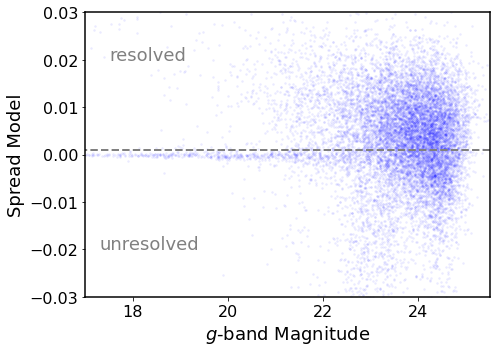

In [7]:
spread_model_cut = 0.001
fig,ax = plt.subplots(1,1,figsize=(7,5), sharey=True)
mag_psf = 22.5 -2.5*np.log10(df_lc_psf['flux_psf'][::1000])
ax.scatter(mag_psf, df_lc_psf['spread_model'][::1000],c='b', s=3, alpha=0.05)
ax.set_ylabel('Spread Model', fontsize=18)
ax.set_xlabel('$g$-band Magnitude', fontsize=18)
ax.tick_params('both',labelsize=16)
ax.hlines(spread_model_cut,14,26, color='grey', lw=2, linestyle='dashed')
ax.set_ylim(-0.03,0.03)
ax.set_xlim(17,25.5)
ax.text(17.5, 0.02, 'resolved', fontsize=18, color='grey')
ax.text(17.3, -0.02, 'unresolved', fontsize=18, color='grey')
fig.tight_layout()
fig.savefig('figures/spreadmodel_dia.pdf', dpi=300)

### Define Selection functions

We adopt the metric reduced median spread (ROMS), based on the robust median absolute deviation sstatistic:

$$ \rm{MAD}_n = med_i( | m_i - \rm{med}_j(m_j) | /  \sigma_i ) $$


We adopt $ \sigma_{\rm var} >3 $ as our AGN candidate sample. See https://opensource.ncsa.illinois.edu/confluence/display/DESDM/Y3A1+SN+Field+Variability+Catalog.

In [8]:
def myvarlc(fluxin,sigin):

    n = np.shape(fluxin)[0]

    #convergence threshold
    tiny = 2.e-5
    #lower limit for extra variance
    #vmin = tiny * v0

    #trap no data
    good = 0.
    avg = 0.
    rms = 0.
    sigavg = -1.
    sigrms = -1.
    if( n <= 0 ):
        print('flux,sig arrays empty, no data',n)
        return(good, avg, rms, sigavg, sigrms)

    #only use data with non zero error bar
    idinc = np.where(sigin > 0)[0]
    flux = fluxin[idinc]
    flux2 = flux * flux
    sig  = sigin[idinc]
    sig2 = sig*sig
    ng = np.shape(sig)[0]

    #trap no valid data
    if( ng <= 0 ):
        print('** ERROR in avgrmsx. n', n, ' ng', ng)
        return(good, avg, rms, sigavg, sigrms)

    #average positive error bars
    e1 = np.mean(sig)
    #KDH : V1 MAY VANISH IF E1 TOO SMALL
    v1 = e1 * e1

    #initial estimate
    x = e1/sig
    x2 = x*x
    sum1 = np.sum(flux*x2)
    sum2 = np.sum(x2)
    varguess = np.std(flux) 


    #optimal average and its variance
    avg = sum1 / sum2
    sigavg = e1 / np.sqrt( sum2 )
    v0 = e1 * ( sigavg / sum2 )

    #scale factor ( makes <1/sig^2>=1 )
    v1 = ng * e1 * ( e1 / sum2 )
    e1 = np.sqrt( v1 )
    v0 = v0 / v1

    #convergence threshold
    tiny = 2.e-5
    #lower limit for extra variance
    vmin = tiny * v0

    #initial parameter guesses
    #avg = 10.0#np.mean(flux)
    #rms = 0.1#np.std(flux)
    var = rms*rms

    #max-likelihood estimate of mean and extra varian
    nloop = 1000
    for loop in range(nloop):
        #stow for convergence test
        oldavg = avg
        oldrms = rms
        oldvar = var

        #rescale
        d = flux/e1
        d2=d*d
        e = sig/e1
        #e2 = e*e
        a = avg/e1

        #weight
        w = 1./(v0 + e*e)
        #"goodness" of the data 
        g = v0 * w
        x = g * (d - a)
        xx = x*x

        sum1 = np.sum(g*d)
        sumg = np.sum(g)
        sum  = np.sum(g*g)
        sum2 = np.sum(xx)
        sum3 = np.sum(g*xx)  
        sum4 = np.sum(x*g)

        a = sum1 / sumg
        v0 = sum2 / sumg
        v0 = max( vmin, v0 )
        va = v0 / sumg
        #new avg and rms
        avg = a
        rms = np.sqrt( v0 )

        #hessian matrix
        Hmm = sumg/v0
        Hmv = sum4/v0/v0
        Hvv = sum3/v0/v0/v0 - 0.5*sum/v0/v0

        #correction for covariance
        c = 1. - Hmv*Hmv/Hmm/Hvv
        #error bars on avg and rms
        sigavg = np.sqrt( 1./Hmm/c )#np.sqrt( va )
        sigv0  = np.sqrt( 1./Hvv/c )

        #g = 2.0 * ( 2.0 * sum3 / sum2 * sumg - sum )

        sigrms = rms
        if( Hvv > 0.0 ): 
            sigrms = 1./2 / rms * sigv0 #combination of error formula for x^1/3

        #restore scaling
        avg = a * e1
        rms = rms * e1
        sigavg = sigavg * e1
        sigrms = sigrms * e1

        #"good" data points ( e.g. with sig < rms )
        if( sumg < 0.0 ):
            print('** ERROR in AVGRMSX. NON-POSITIVE SUM(G)=', gsum)
            print('** loop', loop, ' ndat', n, ' ngood', ng)
            print('** dat(:)', flux[:])
            print('** sig(:)', sig[:])
            good = 0
            return(good, avg, rms, sigavg, sigrms)

        #converge when test < 1
        if( loop > 10 ):
            safe = 0.9
            avg = oldavg * ( 1. - safe ) + safe * avg
            rms = oldrms * ( 1. - safe ) + safe * rms
            chiavg = ( avg - oldavg ) / sigavg
            chirms = ( rms - oldrms ) / sigrms
            test = max( abs( chiavg ), abs( chirms ) ) / tiny
            #report on last 5 iterations
            if( loop > nloop - 3 ):
                print('Loop', loop, ' of', nloop, ' in AVGRMSX')
                print('Ndat', n, ' Ngood', good, ' Neff', g)
                print(' avg', avg, ' rms', rms)
                print(' +/-', sigavg, ' +/-', sigrms)
                print(' chiavg', chiavg, ' chirms', chirms, ' test', test)
            #if( test < 1. ):
            #    print('** CONVERGED ** :))')

            #converged
            if( test < 1. ):
                good = 1
                return(good, avg, rms, sigavg, sigrms)

        #quit if v0 vanishes
        if( v0 <= 0. ): 
            print('no variance var <=0',var)
            return(good, avg, rms, sigavg, sigrms)

        #next loop

    #failed to converge
    print('** AVGRMSX FAILED TO CONVERGE :(((((')
    return(good, avg, rms, sigavg, sigrms)

In [14]:
def reject_outliers(mjd, mag, magerr, m=3.0):
    d = np.abs(mag - np.nanmedian(mag))
    mdev = np.nanmedian(d)
    s = d/mdev if mdev else 0.0
    mask = (s<m)
    return mjd[mask], mag[mask], magerr[mask]

def plot_lc(mjd, mag, magerr):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.errorbar(mjd,mag,yerr=magerr,c='k',fmt='.')
    ax.set_xlabel('Time (MJD)',fontsize=18)
    ax.set_ylabel(r'Magnitude $g$',fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_ylim(np.nanmax(mag)+.1, np.nanmin(mag)-.1)
    fig.tight_layout()
    return ax

def select(dfi, min_epochs=25, plot=False, correct_err=False):
    # Select candidates
    resolved = np.nanmedian(dfi['spread_model'].values) > spread_model_cut
    # Get PSF light curve
    mjd_psf = dfi['mjd_obs'].values
    flux = dfi['flux_psf'].values
    fluxerr = dfi['fluxerr_psf'].values
    # Convert to mag
    mag_psf = 22.5 -2.5*np.log10(flux)
    magerr_psf = 2.5/np.log(10)*fluxerr/flux
    med_mag_psf = np.nanmedian(mag_psf)
    if correct_err:
        # Corrected error adds in quadrature with systematic scatter at the median magnitude
        magerr_psf = np.sqrt(magerr_psf**2 + poly.polyval(med_mag_psf, coefs_psf)**2)
    # Bad flux
    mask = np.isfinite(mag_psf) & (mag_psf>0)
    mjd_psf = mjd_psf[mask]
    mag_psf = mag_psf[mask]
    magerr_psf = magerr_psf[mask]
    # Outlier rejection
    mjd_psf, mag_psf, magerr_psf = reject_outliers(mjd_psf, mag_psf, magerr_psf)
    n_epochs_psf = len(mjd_psf)
    # Magnitude and number of epochs limit
    if med_mag_psf > 17.0 and n_epochs_psf > min_epochs:
        mad_psf = np.nanmedian(np.abs(mag_psf - med_mag_psf)/magerr_psf)
        good, avg, rms, sigavg, sigrms = myvarlc(mag_psf,magerr_psf)
        snr_psf = rms/sigrms
        if not resolved: # Unresolved (PSF)
            rms_psf = np.nanstd(mag_psf, ddof=1)
            if mad_psf > 3 and plot:
                print(dfi['ra'].values[0], dfi['dec'].values[0])
                ax = plot_lc(mjd_psf, mag_psf, magerr_psf)
                ax.text(.05,.9,r'PSF $\sigma_{\rm{var}}=%.1f$' % mad_psf,transform=ax.transAxes,fontsize=18)
                plt.show()
            return mad_psf, rms_psf, med_mag_psf, resolved, n_epochs_psf, snr_psf
        else: # Resolved (DIA)
            ra_as, dec_as = dfi['ra_as'].values[0], dfi['dec_as'].values[0]
            ind = (df_lc_dia['ra_as']==ra_as) & (df_lc_dia['dec_as']==dec_as)
            dfi = df_lc_dia[ind]
            mjd_dia = dfi['mjd_obs'].values
            flux = dfi['flux5'].values # add median of PSF flux to diff flux
            fluxerr = dfi['fluxerr5'].values
            # Convert to mag
            mag_dia = 30 -2.5*np.log10(flux)
            magerr_dia = 2.5/np.log(10)*fluxerr/flux
            # Bad flux
            mask = np.isfinite(mag_dia) & (mag_dia>0)
            mjd_dia = mjd_dia[mask]
            mag_dia = mag_dia[mask]
            magerr_dia = magerr_dia[mask]
            # Outlier rejection
            mjd_dia, mag_dia, magerr_dia = reject_outliers(mjd_dia, mag_dia, magerr_dia)
            med_mag_dia = np.nanmedian(mag_dia)
            n_epochs_dia = len(mjd_dia)
            # Number of epochs limit
            if n_epochs_dia > min_epochs:
                mad_dia = np.nanmedian(np.abs(mag_dia - med_mag_dia)/magerr_dia)
                good, avg, rms, sigavg, sigrms = myvarlc(mag_dia,magerr_dia)
                snr_dia = rms/sigrms
                # A check to avoid spurious DIA light curve
                if mad_dia < mad_psf:
                    # Plot variable sources
                    rms_dia = np.nanstd(mag_dia, ddof=1)
                    if mad_dia > 3 and plot:
                        ax = plot_lc(mjd_psf, mag_psf, magerr_psf)
                        ax.text(.05,.9,r'PSF $\sigma_{\rm{var}}=%.1f$' % mad_psf,transform=ax.transAxes,fontsize=18)
                        plt.show()
                        ax = plot_lc(mjd_dia, mag_dia, magerr_dia)
                        ax.text(.05,.9,r'DIA $\sigma_{\rm{var}}=%.1f$' % mad_dia,transform=ax.transAxes,fontsize=18)
                        plt.show()
                    return mad_dia, rms_dia, med_mag_dia, resolved, n_epochs_dia, snr_dia

In [15]:
# May be faster to add a column for PSF or DIA measurement get rid of DIA match criterea
selected = df_lc_psf.groupby(['ra_as', 'dec_as']).apply(lambda x: select(x, plot=False, correct_err=False))
summary = selected.to_numpy(dtype=[('mad',float),('rms',float),('med_mag',float),('dia',bool),('nepochs',float),('mle_rms',float)])
selected = selected[np.isfinite(summary['med_mag'])] # Clean NaN
summary = summary[np.isfinite(summary['med_mag'])] # Clean NaN
summary_coord = selected.index.to_numpy(dtype=[('ra',float),('dec',float)])
summary_coord = SkyCoord(summary_coord['ra'],summary_coord['dec'],unit=u.arcsec)
del selected # Clear up some memory

### Bootstrap error bars

Do separately for PSF and DIA

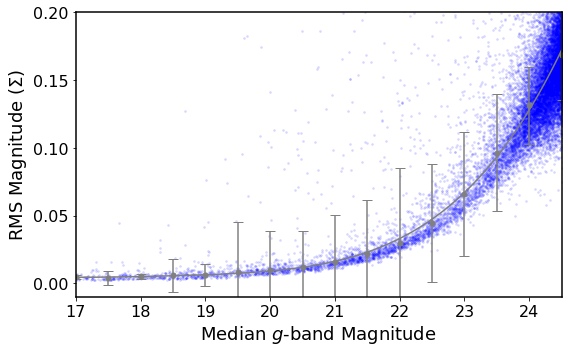

In [33]:
resolved = (summary['dia']==False)

bin_edges = np.arange(16.75,25.25,0.5)
fig,ax = plt.subplots(1,1,figsize=(8,5), sharey=True)
bin_std, bin_edges, binnumber = st.binned_statistic(summary['med_mag'][resolved],summary['rms'][resolved],statistic='std',bins=bin_edges)
bin_med, bin_edges, binnumber = st.binned_statistic(summary['med_mag'][resolved],summary['rms'][resolved],statistic='median',bins=bin_edges)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

# Fit fourth-order polynomial (a la Sesar et al 2007)
x_eval = np.linspace(17,25,100)
coefs_psf = poly.polyfit(bin_centers, bin_med, 4, w=1/bin_std)
ffit = poly.polyval(x_eval, coefs_psf)

ax.scatter(summary['med_mag'],summary['rms'],c='b', s=3, alpha=0.1)
ax.errorbar(bin_centers,bin_med,yerr=bin_std,c='grey',fmt='.',capsize=5, ms=10)
ax.plot(x_eval, ffit,c='grey', lw=1.5)

ax.set_ylim(-0.01,0.2)
ax.set_xlim(17,24.5)
ax.set_ylabel(r'RMS Magnitude ($\Sigma$)', fontsize=18)
ax.set_xlabel('Median $g$-band Magnitude', fontsize=18)
ax.tick_params('both',labelsize=16)
fig.tight_layout()
fig.savefig('figures/correction.pdf', dpi=300)

### Re-compute selection with corrected errors

Corrected errors:

$$ \sigma' = \sqrt{\sigma^2 + \left<\xi(m)\right>^2}$$

51.446604 -27.963075


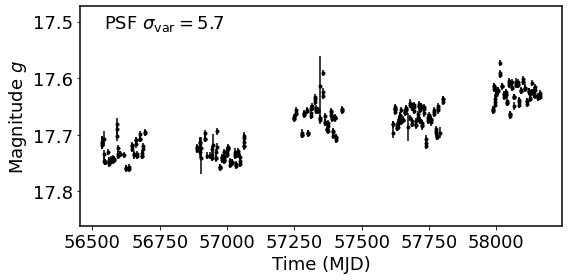

51.602068 -27.943398


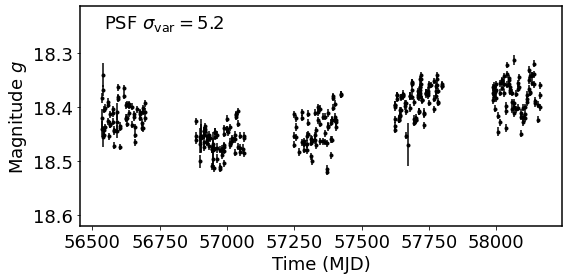

51.6044 -27.745754


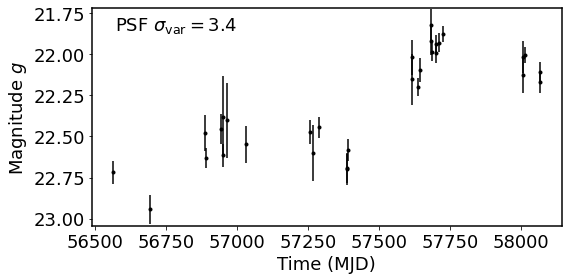

51.619306 -27.910815


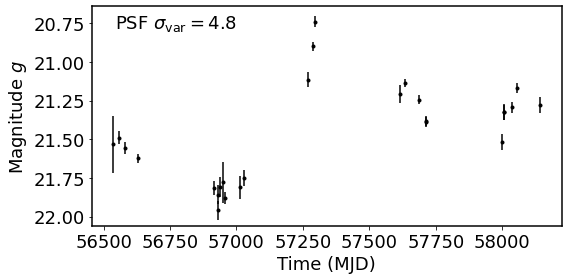

51.619313 -27.910763


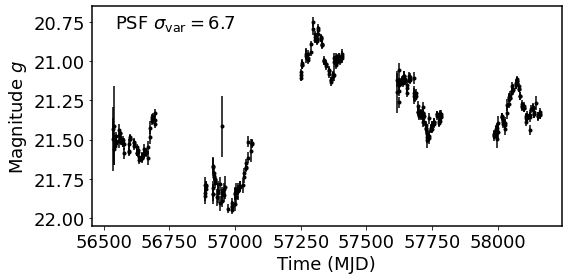

51.647203 -27.969369


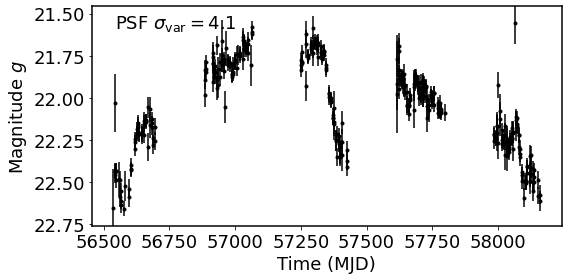

51.729366 -27.760289


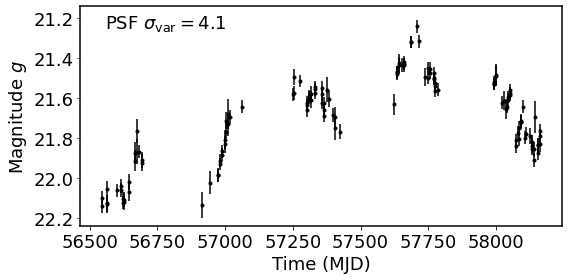

51.729348 -27.760208


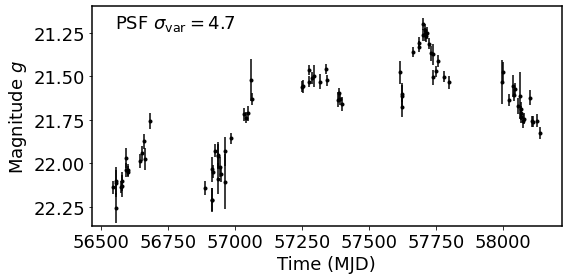

51.731396 -27.822977


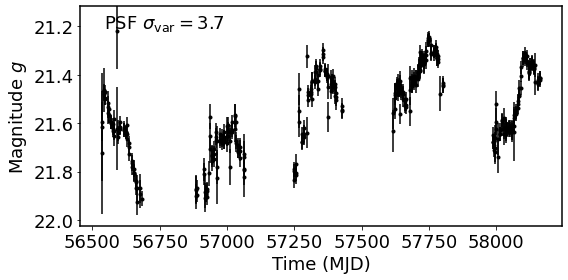

51.736494 -27.791458


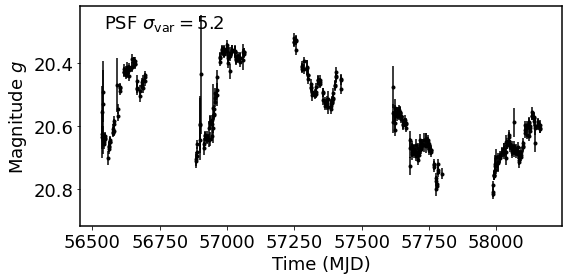

51.765165 -27.740401


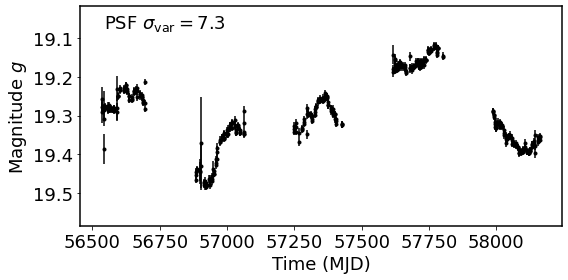

51.798445 -27.923807


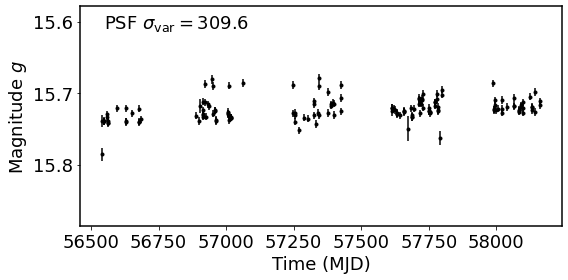

51.830547 -27.62618


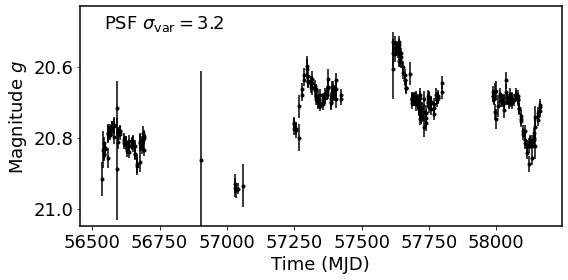

51.853933 -27.700808


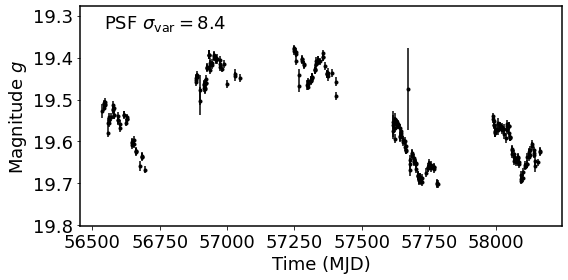

51.853917 -27.700763


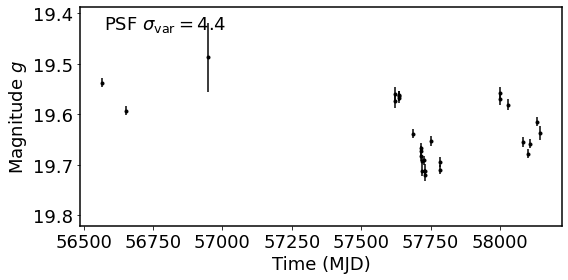

51.970832 -27.724763


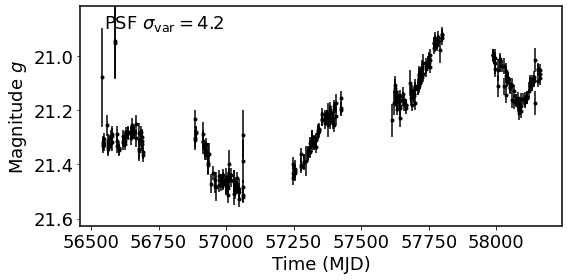

51.980416 -27.86298


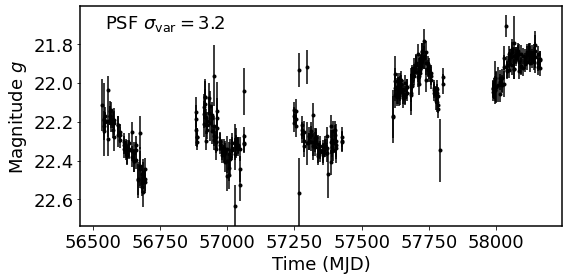

51.999117 -27.548782


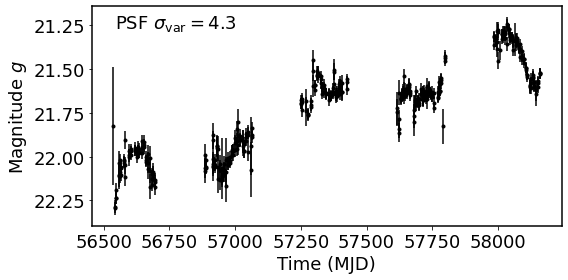

52.007698 -27.637749


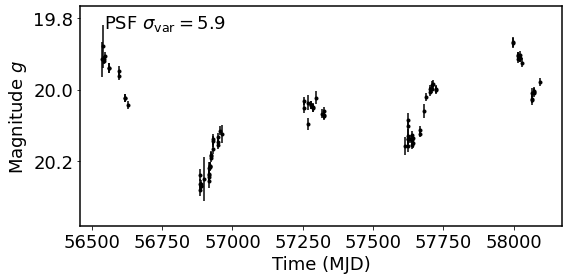

52.017382 -27.590149


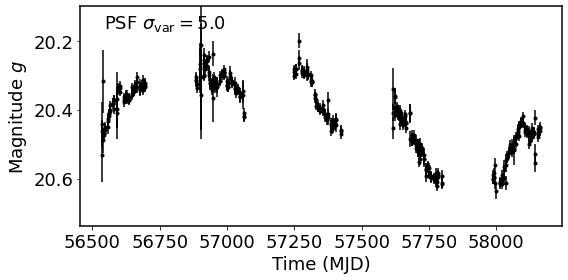

52.099141 -27.970606


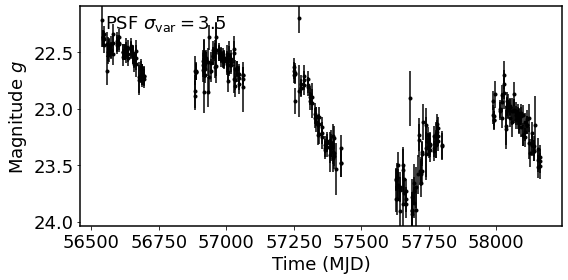

** ERROR in avgrmsx. n 89  ng 0
** ERROR in avgrmsx. n 27  ng 0
52.124899 -27.703451


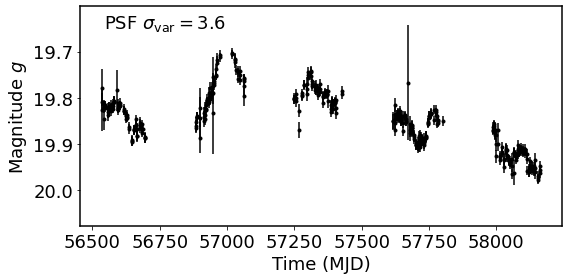

52.136662 -27.78173


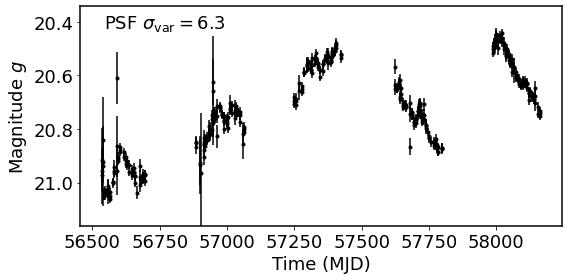

52.148475 -27.735067


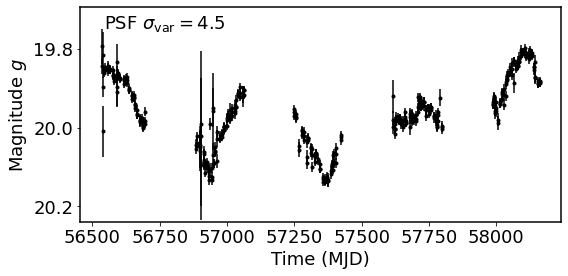

52.159916 -27.780754


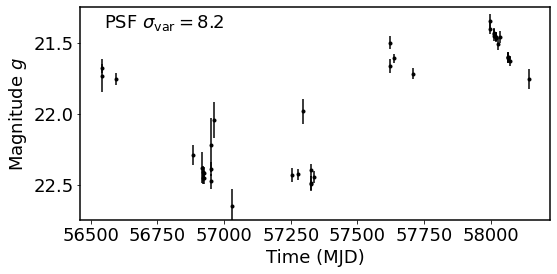

52.159958 -27.780763


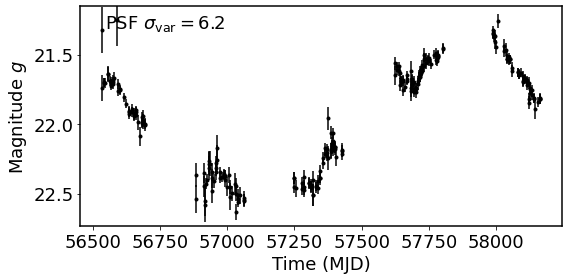

52.164942 -27.883532


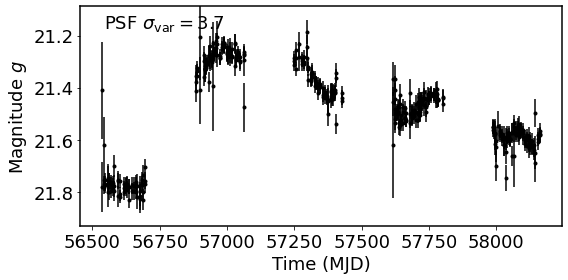

52.258705 -27.663074


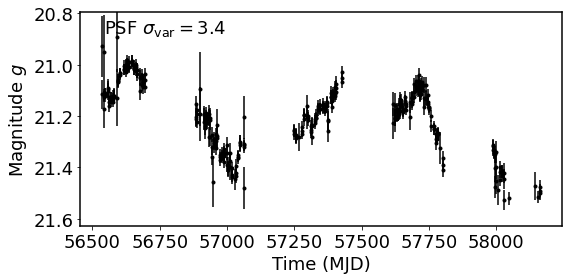

52.332154 -27.865447


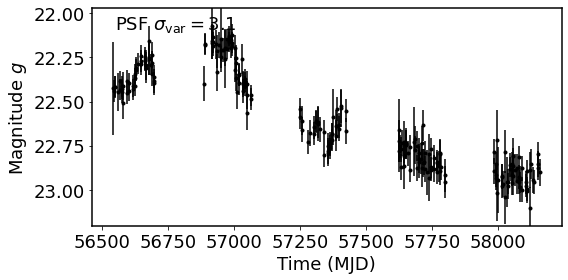

52.364911 -27.733636


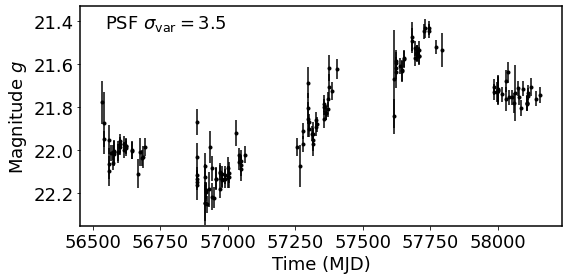

52.364961 -27.796038


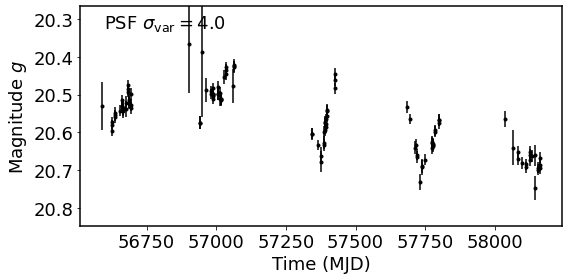

52.365035 -27.73364


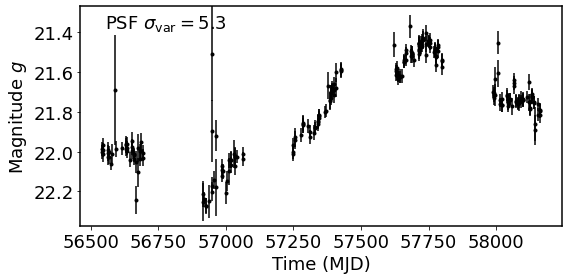

52.378875 -27.791874


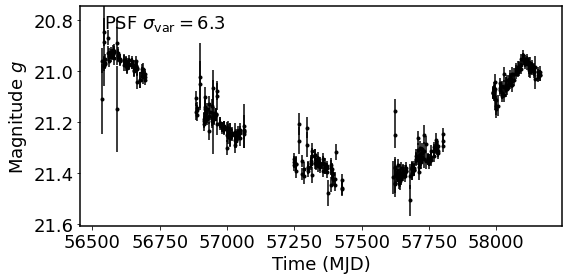

52.397537 -27.657548


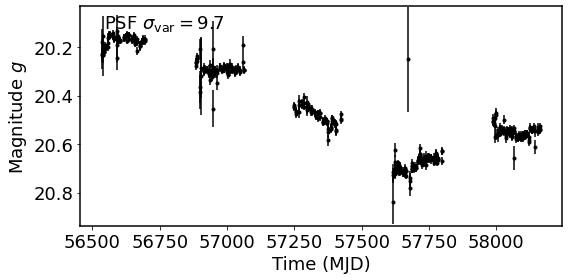

52.418663 -27.862151


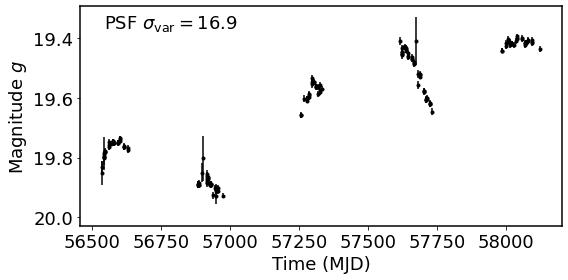

52.418734 -27.862151


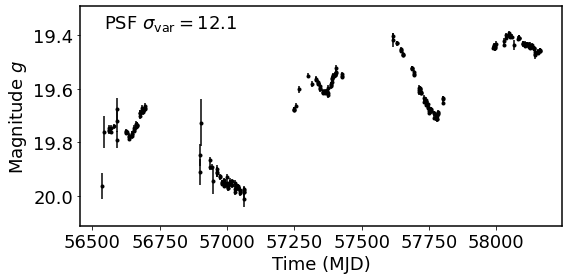

52.486318 -27.689651


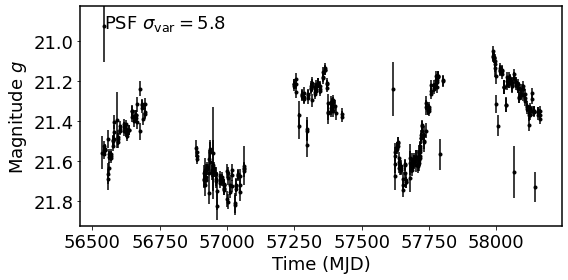

52.489462 -27.801872


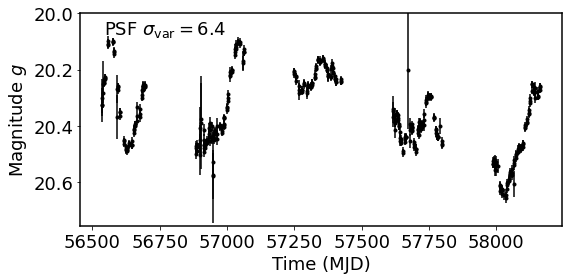

** ERROR in avgrmsx. n 103  ng 0
** ERROR in avgrmsx. n 29  ng 0
** ERROR in avgrmsx. n 78  ng 0
52.510433 -27.816296


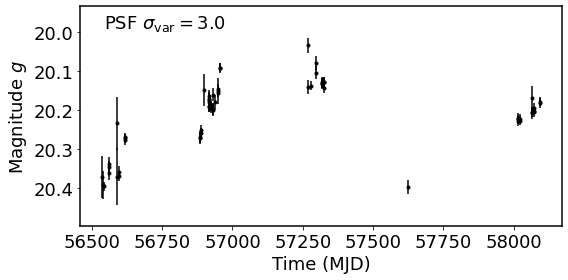

52.510508 -27.816242


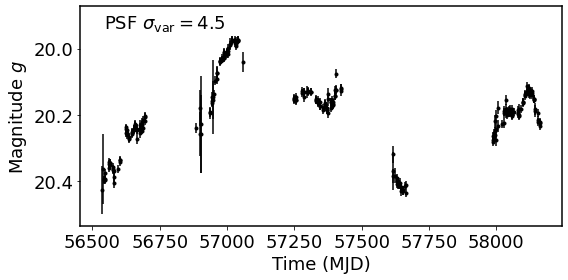

52.51165 -27.710711


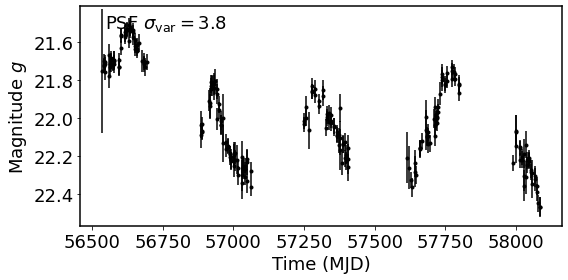

52.511664 -27.710625


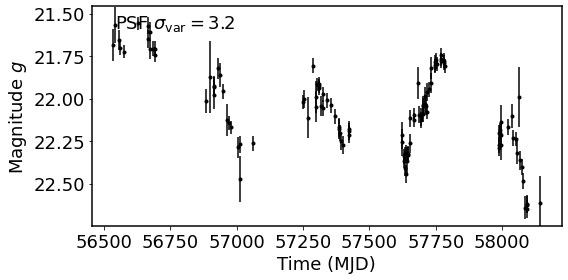

52.522025 -27.724374


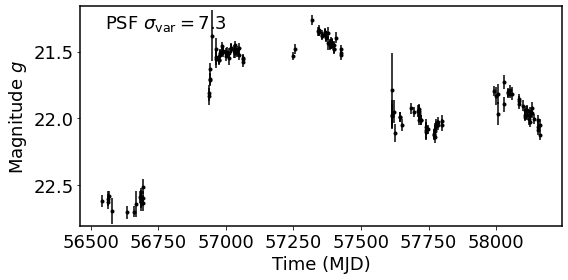

52.550245 -27.649412


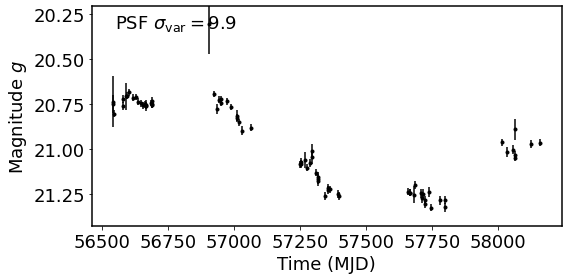

52.550223 -27.649374


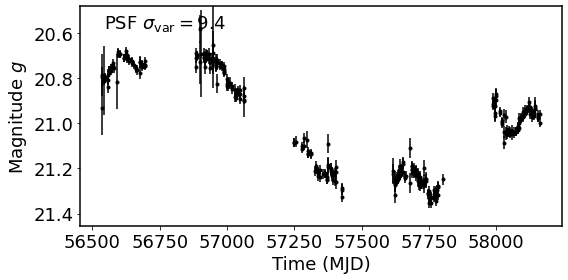

52.57 -27.561366


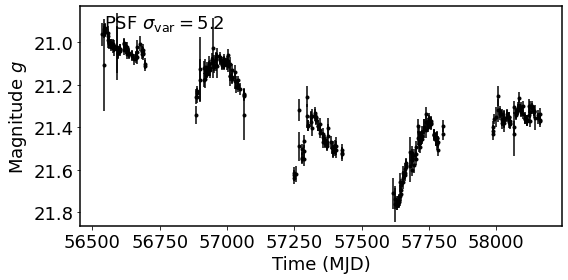

52.581267 -27.6752


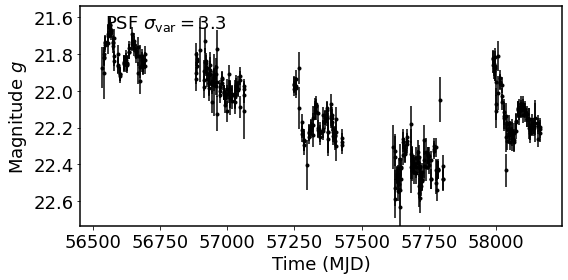

52.598064 -27.836736


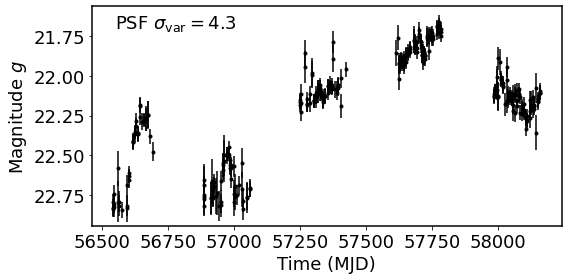

52.598154 -27.836736


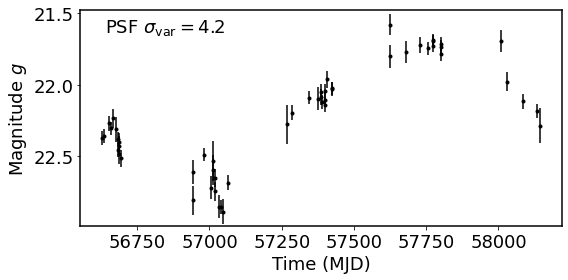

52.605141 -27.597011


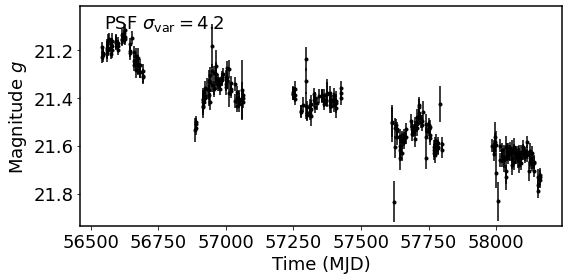

52.61719 -27.626863


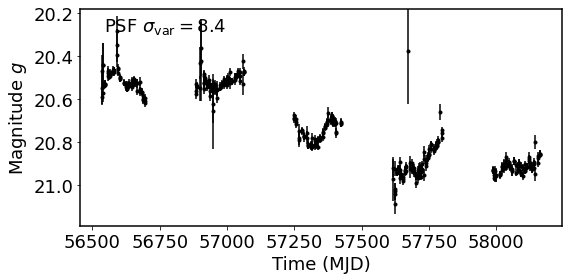

52.654258 -27.756814


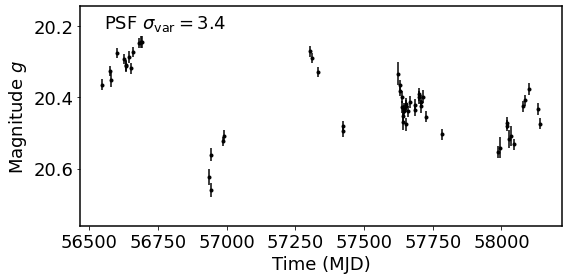

52.667866 -27.701156


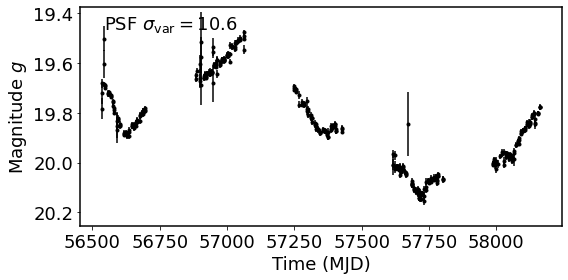

52.67117 -27.717569


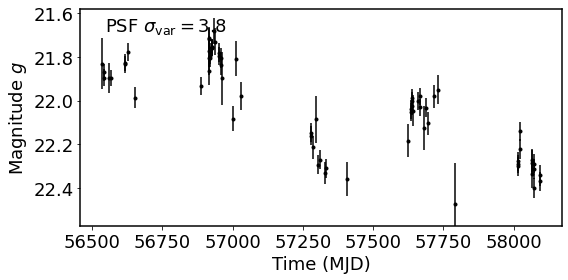

52.671224 -27.717569


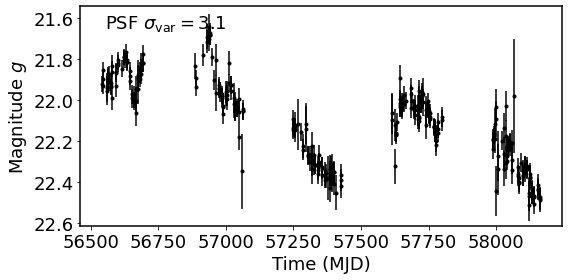

52.673829 -27.949632


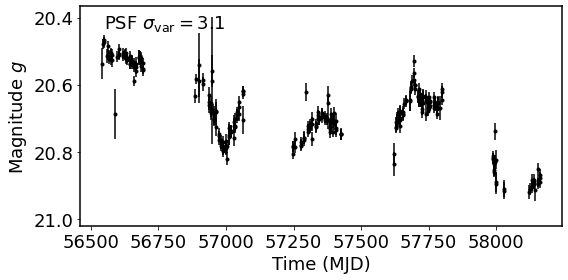

52.676114 -27.58565


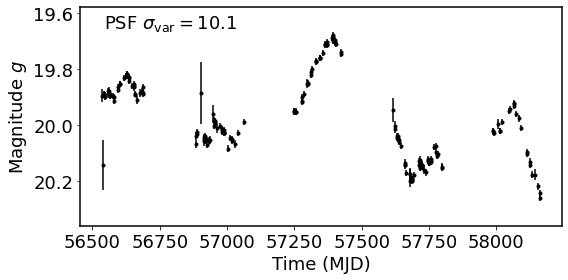

52.676075 -27.585625


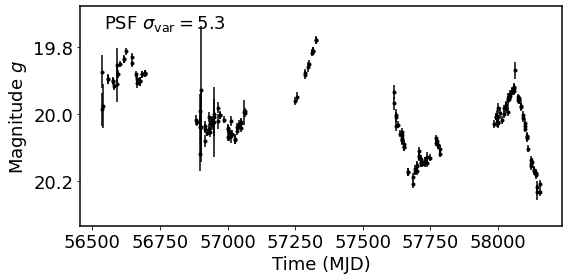

52.680142 -27.694889


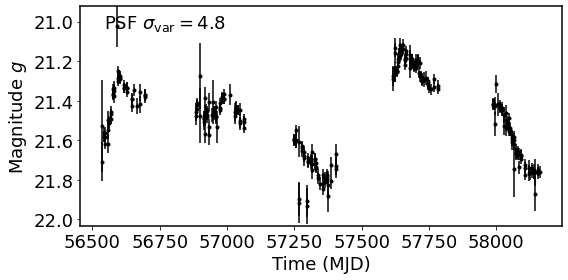

** ERROR in avgrmsx. n 34  ng 0
** ERROR in avgrmsx. n 81  ng 0
52.754881 -27.857134


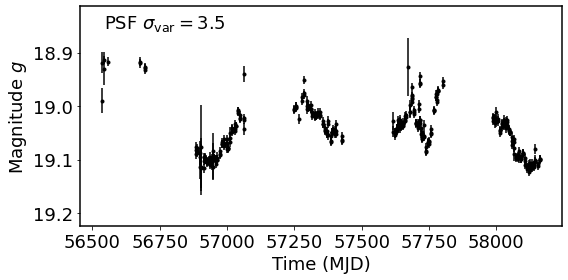

52.785359 -27.834211


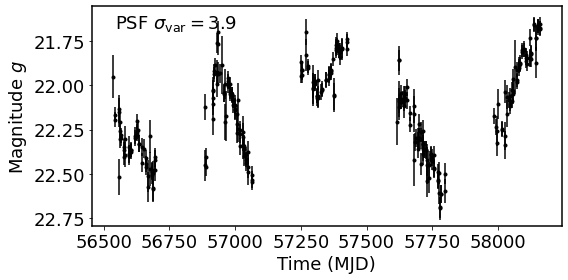

52.785363 -27.834097


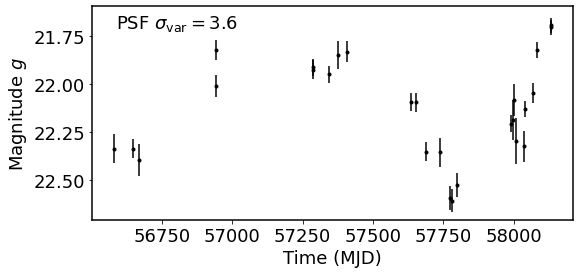

52.797279 -27.560486


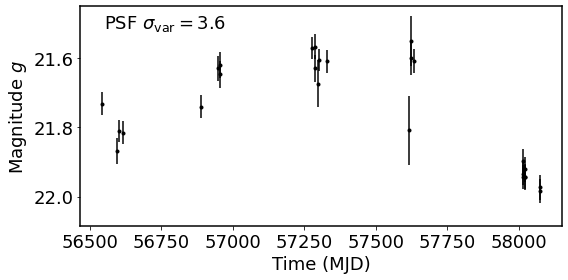

52.797389 -27.692291


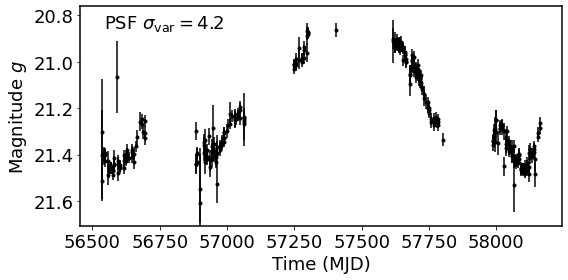

52.880264 -27.57493


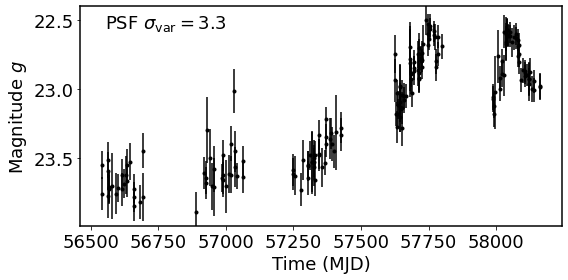

52.938338 -27.910036


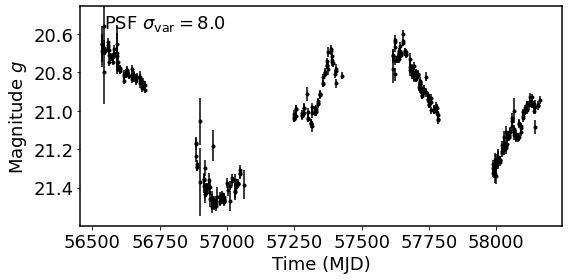

52.938412 -27.909974


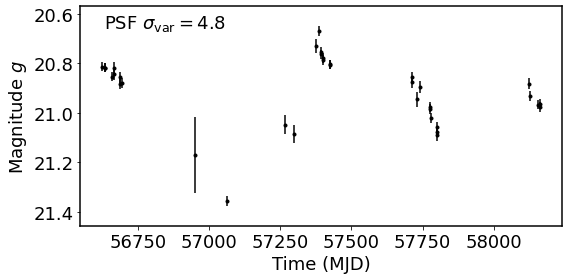

53.016902 -27.623951


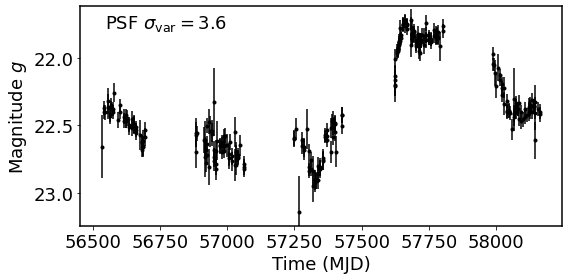

53.036094 -27.792982


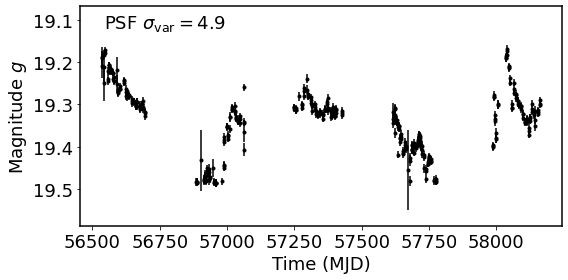

53.039437 -27.802013


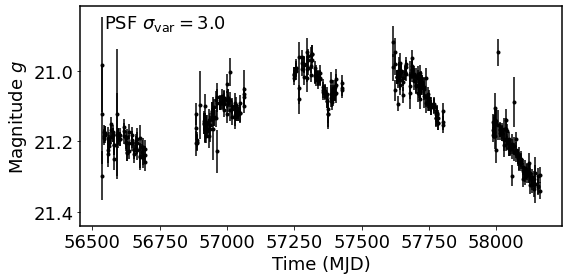

53.040244 -27.994096


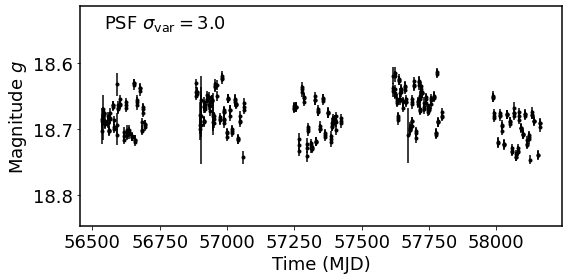

53.048531 -27.623987


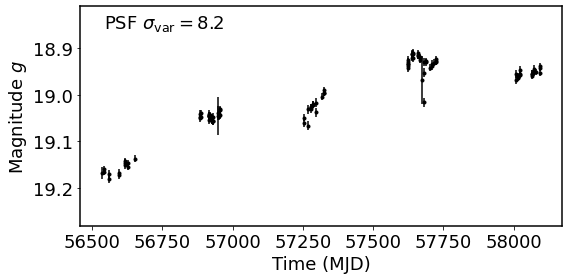

53.048559 -27.623997


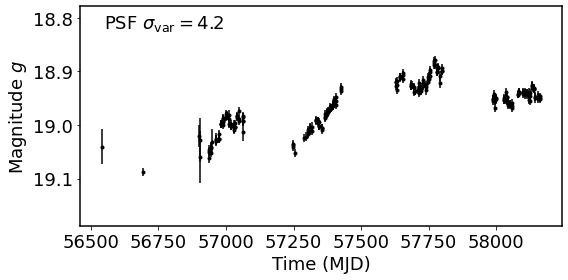

53.067554 -27.65854


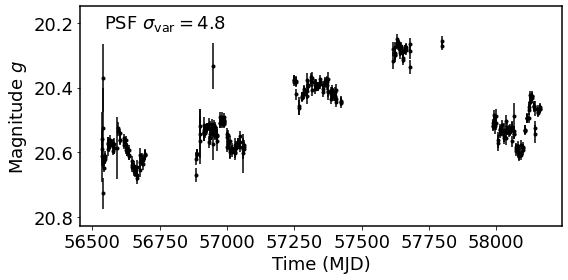

53.110352 -27.676706


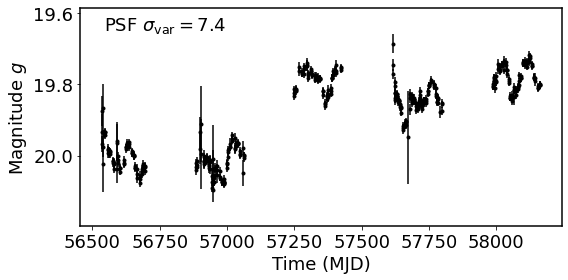

53.112548 -27.684859


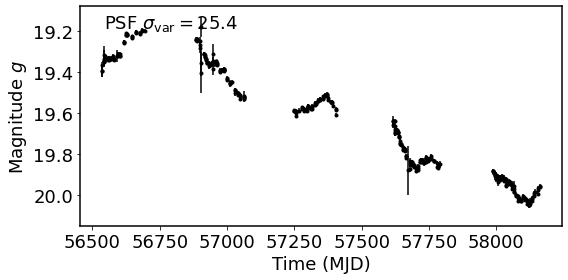

53.112624 -27.684838


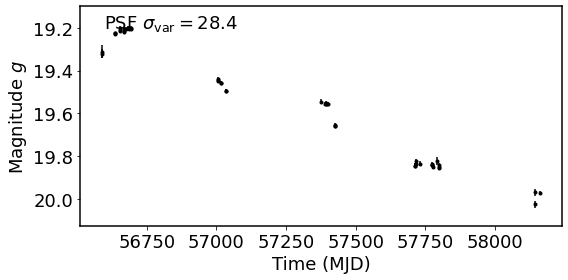

In [ ]:
# May be faster to add a column for PSF or DIA measurement get rid of DIA match criterea
selected = df_lc_psf.groupby(['ra_as', 'dec_as']).apply(lambda x: select(x, plot=True, correct_err=True))
summary = selected.to_numpy(dtype=[('mad',float),('rms',float),('med_mag',float),('dia',bool),('nepochs',float)])
selected = selected[np.isfinite(summary['med_mag'])] # Clean NaN
summary = summary[np.isfinite(summary['med_mag'])] # Clean NaN
summary_coord = selected.index.to_numpy(dtype=[('ra',float),('dec',float)])
summary_coord = SkyCoord(summary_coord['ra'],summary_coord['dec'],unit=u.arcsec)
del selected # Clear up some memory

In [ ]:
# Clear up some memory
del df_lc_psf
del df_lc_dia

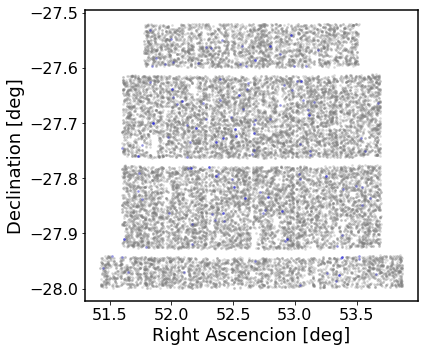

In [28]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(summary_coord.ra.deg,summary_coord.dec.deg,s=3,c='grey',alpha=0.2)
ax.scatter(summary_coord.ra.deg[(summary['mad']>3)],summary_coord.dec.deg[(summary['mad']>3)],s=3,c='b',alpha=0.2)
ax.scatter(summary_coord.ra.deg[(summary['mad']>3)&(summary['dia'])],summary_coord.dec.deg[(summary['mad']>3)&summary['dia']],s=3,c='r',alpha=0.2)

#ax.set_ylim(-29.1,-27.1)
#ax.set_ylim(-29.2,-27.1)
ax.set_ylabel('Declination [deg]', fontsize=18)
ax.set_xlabel('Right Ascencion [deg]', fontsize=18)
ax.tick_params('both',labelsize=16)
fig.tight_layout()
fig.savefig('figures/footprint.pdf', dpi=300)

3.2004096711817875


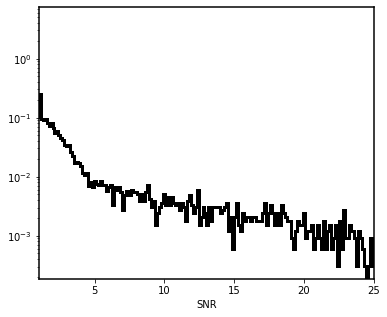

In [25]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
ax.hist(summary['mle_rms'],lw=3,fc='none',ec='k',histtype='step',bins=200,density=True);
print(np.nanstd(summary['mle_rms']))
ax.set_xlim(1, 25)
ax.set_xlabel('SNR')
ax.set_yscale('log')

0.637455394298666
4.242122378917444


Text(0.5, 0, 'RMAD')

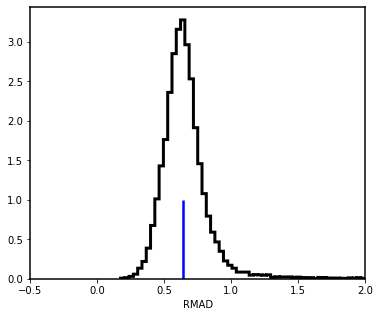

In [26]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
ax.hist(summary['mad'],lw=3,fc='none',ec='k',histtype='step',bins=20000,density=True);
norm_mad = (summary['mad']-np.nanmean(summary['mad']))/np.nanstd(summary['mad'])
#ax.hist(norm_mad,lw=3,fc='none',ec='b',histtype='step',bins=20000,density=True);
# test
ax.vlines(np.nanmedian(summary['mad']),0,1, lw=2.5, linestyle='solid', color='b',zorder=-1, label='median+std')
ax.set_xlim(-0.5, 2)

print(np.nanmedian(summary['mad']))
print(np.nanstd(summary['mad']))

ax.set_xlabel(r'RMAD')

(-0.5, 5.0)

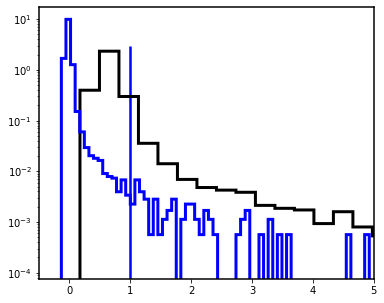

In [27]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
ax.hist(summary['mad'],lw=3,fc='none',ec='k',histtype='step',bins=2000,density=True);
norm_mad = (summary['mad']-np.nanmean(summary['mad']))/np.nanstd(summary['mad'])
ax.hist(norm_mad,lw=3,fc='none',ec='b',histtype='step',bins=2000,density=True);
# test
ax.vlines(np.std(norm_mad),0,3, lw=2.5, linestyle='solid', color='b',zorder=-1, label='median+std')

ax.set_yscale('log')
ax.set_xlim(-0.5, 5)

At > 2$\sigma$, these distributions are not that different.

0.4629888185620009


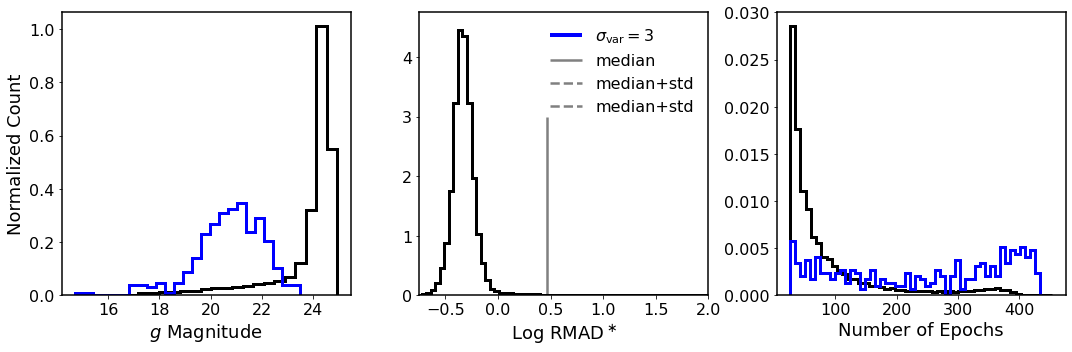

In [83]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
ax.hist(summary['med_mag'],lw=3,fc='none',ec='k',histtype='step',bins=25,density=True)
ax.hist(summary['med_mag'][summary['mad']>3],lw=3,fc='none',ec='b',histtype='step',bins=25,density=True)
ax.set_ylabel('Normalized Count', fontsize=18)
ax.set_xlabel('$g$ Magnitude', fontsize=18)
ax.tick_params('both',labelsize=16)
ax = axs[1]
ax.vlines(3,0,1.4, lw=4, color='b',zorder=-1, label=r'$\sigma_{\rm{var}}=3$')
print(np.median(summary['mad']))
ax.vlines(np.median(summary['mad']),0,3, lw=2.5, color='grey',zorder=-1, label='median')
ax.vlines(np.median(summary['mad'])+np.std(summary['mad']),0,1.4, lw=2.5, linestyle='dashed', color='grey',zorder=-1, label='median+std')
ax.vlines(np.median(summary['mad'])+3*np.std(summary['mad']),0,1.4, lw=2.5, linestyle='dashed', color='grey',zorder=-1, label='median+std')
ax.hist(np.log10(summary['mad']),lw=3,fc='none',ec='k',histtype='step',bins=80,density=True)
ax.legend(fontsize=16,frameon=False)
ax.set_ylim(0,4.75)
#ax.hist(summary['mad'][summary['mad']>3],lw=3,fc='none',ec='b',histtype='step',bins=25,density=True)
ax.set_xlabel(r'Log RMAD$^\ast$', fontsize=18)
ax.set_xlim(-0.75, 2)
ax.tick_params('both',labelsize=16)
ax = axs[2]
ax.hist(summary['nepochs'],lw=3,fc='none',ec='k',histtype='step',bins=50,density=True)
ax.hist(summary['nepochs'][summary['mad']>3],lw=3,fc='none',ec='b',histtype='step',bins=50,density=True)
ax.set_xlabel(r'Number of Epochs', fontsize=18)
ax.tick_params('both',labelsize=16)

#ax.set_xlim(75, 300)

fig.tight_layout()

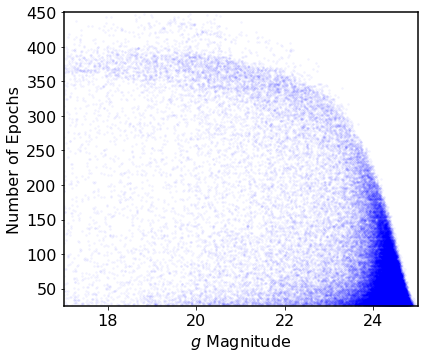

In [87]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(summary['med_mag'],summary['nepochs'],s=3,c='blue',alpha=0.03)
ax.set_xlim(17,25)
ax.set_ylim(25,450)
ax.set_ylabel('Number of Epochs', fontsize=16)
ax.set_xlabel('$g$ Magnitude', fontsize=16)
ax.tick_params('both',labelsize=16)
fig.tight_layout()

### Match to OzDES DR2

Q = 4: redshift based on multiple strong spectroscopic features matched, > 99% confidence.

Q = 3: redshift based typically on a single strong spectroscopic feature or multiple weak features, >95% confidence.

Q = 2: potential redshift associated with typically a single weak feature, low confidence, not to be used for science.

Q = 1: no matching features, thus no constraints on redshift.

Q = 6: securely classified star.

Each object may have one or more object types associated to it. For example an object may have been selected because it hosted a transient or because it a Luminious Red Galaxy (LRG).

Some transients were classified spectroscopically. For these cases, the type is listed.

In [28]:
df_ozdes = pd.read_csv('data/ozdes_dr2.csv')
# Clean NaN and requires Q > 2
df_ozdes = df_ozdes[(~np.isnan(df_ozdes['alpha_j2000'])) & (df_ozdes['qop']>2)]
coord_ozdes = SkyCoord(df_ozdes['alpha_j2000'], df_ozdes['delta_j2000'], unit=u.deg)
df_ozdes_agn = df_ozdes[df_ozdes['object_types'].str.contains("AGN")]
coord_ozdes_agn = SkyCoord(df_ozdes_agn['alpha_j2000'], df_ozdes_agn['delta_j2000'], unit=u.deg)

In [29]:
df_ozdes

,80ea4408-ce2d-4a15-81eb-f77a9c7770b3.csv,ozdes_id,alpha_j2000,delta_j2000,rmag,object_types,z,qop,transient_type,comment
5,5.0,OzDES-DR2_00006,34.739462,-5.199134,19.66,DEVILS,0.22024,4.0,None,None
6,6.0,OzDES-DR2_00007,35.432856,-5.198790,18.93,DEVILS,0.32280,3.0,None,None
7,7.0,OzDES-DR2_00008,34.132414,-5.193920,19.41,DEVILS,0.34798,4.0,None,None
8,8.0,OzDES-DR2_00009,35.278100,-5.194779,19.17,DEVILS,0.35615,4.0,None,None
9,9.0,OzDES-DR2_00010,34.754187,-5.192430,19.28,DEVILS,0.46853,4.0,None,None
...,...,...,...,...,...,...,...,...,...,...
38616,38616.0,Y1A1_COADD_DFULL-3173879184,54.011643,-27.510912,19.51,BrightGalaxy,0.19670,4.0,None,None
38617,38617.0,Y1A1_COADD_DFULL-3173879956,53.971192,-27.505297,19.54,BrightGalaxy,0.18022,4.0,None,None
38621,38621.0,DES17C3gyp,51.966125,-28.395639,24.40,Transient,0.47000,3.0,SLSN I?,None
38622,38622.0,DES17C3gzu,52.328958,-28.770083,23.50,Transient,0.53800,3.0,SN Ia?,None


In [30]:
np.unique(df_ozdes['transient_type'].to_numpy().astype('str'))

array(['None', 'SLSN I?', 'SLSN II?', 'SN I', 'SN II', 'SN II?', 'SN Ia',
       'SN Ia-91T', 'SN Ia?', 'SN Ib', 'SN Ibc', 'SN Ibc?', 'SN Ic'],
      dtype='<U9')

In [31]:
np.unique(df_ozdes['object_types'].to_numpy().astype('str'))

array(['AGN_monitoring,AGN_reverberation',
       'AGN_monitoring,AGN_reverberation,BrightGalaxy',
       'AGN_monitoring,AGN_reverberation,Photo-z',
       'AGN_monitoring,AGN_reverberation,Photo-z,SN_host',
       'AGN_monitoring,AGN_reverberation,RadioGalaxy_I',
       'AGN_monitoring,AGN_reverberation,SN_host',
       'AGN_monitoring,AGN_reverberation,XXL_QSO',
       'AGN_monitoring,BrightGalaxy,AGN_reverberation',
       'AGN_monitoring,BrightGalaxy,AGN_reverberation,RadioGalaxy_I',
       'AGN_monitoring,Photo-z,AGN_reverberation',
       'AGN_monitoring,Photo-z,AGN_reverberation,BrightGalaxy',
       'AGN_monitoring,Photo-z,AGN_reverberation,ClusterGalaxy_II',
       'AGN_monitoring,Photo-z,AGN_reverberation,SN_host',
       'AGN_monitoring,RadioGalaxy_I,AGN_reverberation',
       'AGN_reverberation', 'AGN_reverberation,AGN_monitoring',
       'AGN_reverberation,AGN_monitoring,BrightGalaxy',
       'AGN_reverberation,AGN_monitoring,ELG',
       'AGN_reverberation,AGN_monitoring

In [32]:
idx,d2d,d3d = summary_coord[(summary['mad']>3)].match_to_catalog_sky(coord_ozdes)
match = d2d < 3*u.arcsec
desXozdes = match
ozdesXdes = idx[match]
print('Found %d variable matches to OzDES.' % len(ozdesXdes))

Found 135 variable matches to OzDES.


In [40]:
idx,d2d,d3d = summary_coord.match_to_catalog_sky(coord_ozdes_agn)
match = d2d < 3*u.arcsec
desXozdes_agn = match
ozdesXdes_agn = idx[match]
print('Found %d variable matches to OzDES AGN.' % len(ozdesXdes_agn))

Found 236 variable matches to OzDES AGN.


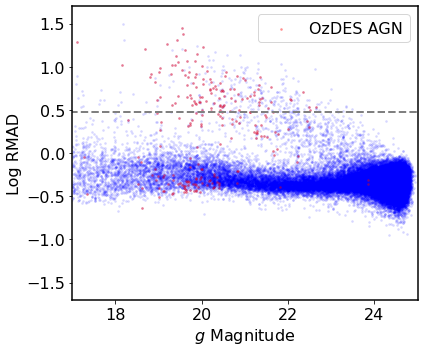

In [99]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(summary['med_mag'],np.log10(summary['mad']),s=3,c='blue',alpha=0.1)
ax.scatter(summary['med_mag'][desXozdes_agn],np.log10(summary['mad'][desXozdes_agn]),s=3,c='r',alpha=0.3,label='OzDES AGN')
ax.hlines(np.log10(3),14,26, color='grey', lw=2, linestyle='dashed')
ax.set_xlim(17,25)
ax.set_ylim(-1.7,1.7)
ax.set_ylabel(r'Log RMAD', fontsize=16)
ax.set_xlabel('$g$ Magnitude', fontsize=16)
ax.tick_params('both',labelsize=16)
fig.tight_layout()
ax.legend(fontsize=16)

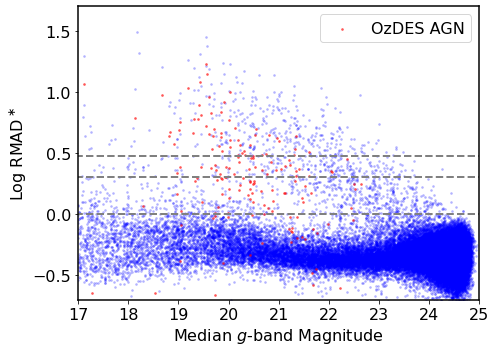

In [108]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.scatter(summary['med_mag'],np.log10(summary['mad']),s=3,c='blue',alpha=0.2)
ax.scatter(summary['med_mag'][desXozdes_agn],np.log10(norm_mad[desXozdes_agn]),s=3,c='r',alpha=0.5,label='OzDES AGN')
ax.hlines(np.log10(3),14,26, color='grey', lw=2, linestyle='dashed')
ax.hlines(np.log10(2),14,26, color='grey', lw=2, linestyle='dashed')
ax.hlines(np.log10(1),14,26, color='grey', lw=2, linestyle='dashed')
ax.set_xlim(17,25)
ax.set_ylim(-.7,1.7)
ax.set_ylabel(r'Log RMAD$^\ast$', fontsize=16)
ax.set_xlabel('Median $g$-band Magnitude', fontsize=16)
ax.tick_params('both',labelsize=16)
fig.tight_layout()
ax.legend(fontsize=16)

### Save final catalog for OzDES spectra

In [149]:
data = list(zip(summary_coord[(summary['mad']>3)].ra.deg[desXozdes], summary_coord[(summary['mad']>3)].dec.deg[desXozdes]))
np.savetxt('data/des_c3_varXozDES.dat', data)